In [41]:
# predict the next rssi value from current time value
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import glob
import os
from tensorflow.contrib.tensorboard.plugins import projector
%matplotlib inline

In [42]:
def make_mini_batch(train_data, size_of_mini_batch, length_of_sequences):
    inputs  = np.empty(0)
    for _ in range(size_of_mini_batch):
        d = random.choice(train_data)
        inputs  = np.append(inputs, d)
    inputs  = inputs.reshape(-1, length_of_sequences)
    return inputs

In [43]:
# test code
data = make_mini_batch(train_data, size_of_mini_batch, num_of_sequence_length)
np.shape(data)

(9, 10)

In [44]:
a = [1,2,3]
b = [a for i in range(3)]
ba = np.array(b)
ba.reshape(-1, 3, 1)

array([[[1],
        [2],
        [3]],

       [[1],
        [2],
        [3]],

       [[1],
        [2],
        [3]]])

In [45]:
glob.glob("./input/data.csv")

['./input/data.csv']

In [53]:
#''' pred area judgement from rssi
train_data_path             = "./input/data.csv"
num_of_sequence_length      = 10
num_of_hidden_nodes         = 5
num_of_training_epochs      = 1000
size_of_mini_batch          = 10
size_of_test_batch          = 4
learning_rate               = 0.02
train_dir                   = 'train'

In [47]:
train_data = np.loadtxt(train_data_path, delimiter=",", dtype=np.float32)
train_data = train_data * 0.1
train_data

array([[ 0.1       ,  0.2       ,  0.30000001,  0.40000001,  0.5       ,
         0.60000002,  0.69999999,  0.80000001,  0.90000004,  0.5       ],
       [ 0.1       ,  0.2       ,  0.30000001,  0.40000001,  0.5       ,
         0.60000002,  0.69999999,  0.80000001,  0.90000004,  0.5       ]], dtype=float32)

In [48]:
# random seed fix
random.seed(0)
np.random.seed(0)
tf.set_random_seed(0)

In [54]:
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

with tf.Graph().as_default():
    input_ph      = tf.placeholder(tf.float32, [None, num_of_sequence_length], name="input")
    supervisor_ph = tf.placeholder(tf.float32, [None, num_of_sequence_length], name="supervisor")
    batch_size_ph = tf.placeholder(tf.int32, name="batch_size")

    with tf.name_scope("inference") as scope:
        weight_var = tf.Variable(tf.truncated_normal([num_of_sequence_length, num_of_hidden_nodes], stddev=0.1), name="weight")
        bias1_var   = tf.Variable(tf.truncated_normal([num_of_hidden_nodes], stddev=0.1), name="bias1")
        bias2_var   = tf.Variable(tf.truncated_normal([num_of_sequence_length], stddev=0.1), name="bias2")

        weight_hist = tf.histogram_summary("layer/weights", weight_var)
        bias1_hist = tf.histogram_summary("layer/biases1", bias1_var)
        bias2_hist = tf.histogram_summary("layer/biases2", bias2_var)

        hidden = tf.sigmoid(tf.matmul(input_ph, weight_var) + bias1_var)
        output_op = tf.sigmoid(tf.matmul(hidden, tf.transpose(weight_var) + bias2_var))

    with tf.name_scope("loss") as scope:
        square_error = tf.reduce_mean(tf.square(output_op - supervisor_ph))
        loss_op      = square_error
        tf.scalar_summary("loss", loss_op)

    with tf.name_scope("training") as scope:
        training_op = optimizer.minimize(loss_op)

#    with tf.name_scope("test") as scope:
#        judge = tf.select(tf.greater(output_op, 0.5), tf.zeros_like(output_op, dtype=tf.float32), tf.ones_like(output_op, dtype=tf.float32))
#        valid = tf.select(tf.equal(judge, supervisor_ph), tf.zeros_like(judge, dtype=tf.float32), tf.ones_like(judge, dtype=tf.float32))
#        accuracy_op = tf.reduce_mean(valid)

    summary_op = tf.merge_all_summaries()
    init = tf.initialize_all_variables()

    with tf.Session() as sess:
        saver = tf.train.Saver()
        summary_writer = tf.train.SummaryWriter("train", graph=sess.graph)
        sess.run(init)

        for epoch in range(num_of_training_epochs):
            data = make_mini_batch(train_data, size_of_mini_batch, num_of_sequence_length)

            train_dict = {
                input_ph:      data,
                supervisor_ph: data,
                batch_size_ph: size_of_mini_batch,
            }
            sess.run(training_op, feed_dict=train_dict)

            if (epoch + 1) % 10 == 0:
                summary_str, train_loss = sess.run([summary_op, loss_op], feed_dict=train_dict)
                summary_writer.add_summary(summary_str, epoch)
                
                # eval accuracy
#                data = make_mini_batch(train_data, size_of_test_batch, num_of_sequence_length)
                data = make_mini_batch(train_data, size_of_mini_batch, num_of_sequence_length)
                pred_dict = {
                    input_ph:      data,
                    supervisor_ph: data,
                    batch_size_ph: size_of_test_batch,
                }
                preddata = sess.run(output_op, feed_dict=pred_dict)
                print(preddata[0])

                print("train#%d, train loss: %e" % (epoch + 1, train_loss))
                
#        saver.save(sess, os.path.join(train_dir, "model.ckpt"), num_of_training_epochs)
#        projector.visualize_embeddings(summary_writer, config)

"""
        for k, d in train_data.items():
            print(k)
            inputs, supervisors = make_a_specified_file_batch(train_data, length_of_sequences, k)
            pred_dict = {
                input_ph:      inputs,
                supervisor_ph: supervisors,
                batch_size_ph: len(inputs),
            }
            pred = (sess.run(output_op, feed_dict=pred_dict))
            pred_bool = [v[0] > 0.5 for v in pred]
            judge = np.empty(0, dtype=np.float32)
            for i in range(len(pred_bool)):
                judge = np.append(judge, pred_bool[i] == supervisors[i])
            print(judge)
            pred_bool_n = [1 if x else 0 for x in pred_bool]
            d[:,3] = [0 for x in range(length_of_sequences)] + pred_bool_n
#            train_data[k] = np.c_[d, [0 for x in range(length_of_sequences)] + pred_bool_n]
                
#        saver.save(sess, "data/model")
"""


[ 0.19268803  0.16771755  0.23623405  0.39893746  0.48990431  0.67617089
  0.74065357  0.80963498  0.84617352  0.51407325]
train#10, train loss: 2.444527e-03
[ 0.08580091  0.13140231  0.3279056   0.39422444  0.49070397  0.54644465
  0.77393848  0.87499166  0.92461771  0.4995667 ]
train#20, train loss: 2.037079e-03
[ 0.07071947  0.19625686  0.28976741  0.39570615  0.49653515  0.62333131
  0.66780752  0.83293557  0.92858094  0.49483272]
train#30, train loss: 4.515533e-04
[ 0.07440659  0.22742398  0.29992598  0.39815509  0.50125724  0.58892792
  0.68004984  0.77828449  0.91872644  0.4973883 ]
train#40, train loss: 2.761750e-04
[ 0.07865456  0.19250092  0.30214089  0.39879546  0.49960989  0.60543537
  0.72091156  0.78635871  0.91235459  0.49772686]
train#50, train loss: 1.328775e-04
[ 0.08832822  0.19404411  0.29802409  0.40025106  0.49973932  0.59513873
  0.69579363  0.80165726  0.90136397  0.499376  ]
train#60, train loss: 2.220602e-05
[ 0.09611879  0.20449632  0.30125934  0.40061033  0.

'\n        for k, d in train_data.items():\n            print(k)\n            inputs, supervisors = make_a_specified_file_batch(train_data, length_of_sequences, k)\n            pred_dict = {\n                input_ph:      inputs,\n                supervisor_ph: supervisors,\n                batch_size_ph: len(inputs),\n            }\n            pred = (sess.run(output_op, feed_dict=pred_dict))\n            pred_bool = [v[0] > 0.5 for v in pred]\n            judge = np.empty(0, dtype=np.float32)\n            for i in range(len(pred_bool)):\n                judge = np.append(judge, pred_bool[i] == supervisors[i])\n            print(judge)\n            pred_bool_n = [1 if x else 0 for x in pred_bool]\n            d[:,3] = [0 for x in range(length_of_sequences)] + pred_bool_n\n#            train_data[k] = np.c_[d, [0 for x in range(length_of_sequences)] + pred_bool_n]\n                \n#        saver.save(sess, "data/model")\n'

,accuracy,epoch
0,0.78,9
1,0.80,19
2,0.78,29
3,0.78,39
4,0.78,49


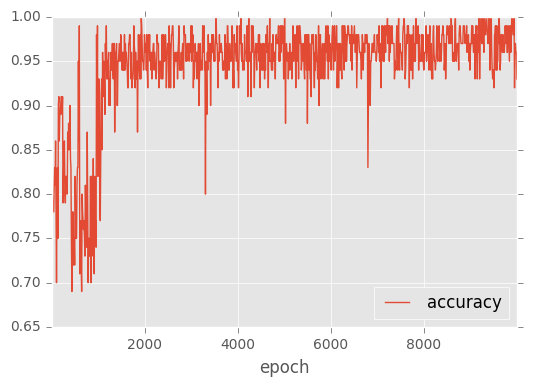

In [33]:
## result graph　
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot') 
font = {'family' : 'meiryo'}
matplotlib.rc('font', **font)

#accuracy = [0.810000, 0.720000, 0.920000, 0.800000, 0.730000, 0.790000, 0.750000, 0.700000, 0.770000, 0.720000, 0.740000, 0.930000, 0.940000, 0.810000, 0.850000, 0.960000, 0.940000, 0.800000, 0.750000, 0.920000, 0.960000, 0.960000, 0.890000, 0.950000, 0.950000, 0.940000, 0.970000, 0.900000, 0.990000, 0.950000, 0.960000, 0.990000, 0.960000, 0.940000, 0.950000, 0.980000, 0.950000, 0.960000, 0.980000, 0.980000, 0.910000, 0.930000, 0.970000, 0.960000, 0.960000, 0.940000, 0.970000, 0.950000, 0.980000, 0.970000, 0.930000, 0.970000, 0.980000, 0.900000, 0.970000, 0.970000, 0.940000, 0.990000, 0.990000, 0.980000, 0.960000, 0.980000, 0.990000, 0.990000, 0.980000, 0.980000, 0.850000, 0.900000, 0.910000, 0.980000, 0.970000, 0.960000, 0.980000, 0.980000, 0.990000, 0.950000, 0.970000, 0.970000, 0.980000, 0.960000, 0.980000, 0.980000, 0.990000, 0.940000, 0.990000, 0.980000, 0.990000, 1.000000, 0.990000, 1.000000, 0.930000, 0.990000, 0.960000, 0.980000, 0.990000, 0.940000, 0.950000, 0.980000, 0.990000, 1.000000, 0.980000, 0.990000, 0.970000, 1.000000, 0.980000, 0.990000, 0.970000, 0.980000, 0.970000, 1.000000, 0.980000, 0.940000, 0.950000, 0.980000, 0.980000, 0.990000, 0.990000, 0.980000, 0.990000, 0.980000, 0.970000, 0.980000, 0.980000, 0.990000, 0.980000, 1.000000, 0.980000, 0.970000, 0.970000, 1.000000, 0.990000, 0.970000, 0.990000, 0.970000, 0.970000, 0.970000, 0.850000, 0.980000, 0.990000, 1.000000, 0.960000, 0.990000, 0.980000, 1.000000, 0.980000, 1.000000, 1.000000, 0.930000, 0.940000, 0.900000, 0.950000, 0.780000, 0.920000, 0.930000, 1.000000, 0.930000, 0.990000, 1.000000, 0.990000, 0.950000, 0.980000, 0.980000, 0.930000, 0.910000, 0.970000, 0.920000, 0.950000, 0.930000, 0.950000, 0.970000, 0.980000, 0.970000, 0.970000, 0.960000, 0.970000, 0.930000, 0.970000, 0.990000, 0.970000, 0.990000, 0.980000, 0.980000, 0.980000, 0.980000, 0.960000, 0.970000, 0.990000, 0.990000, 0.980000, 0.970000, 0.970000, 0.970000, 0.980000, 0.970000, 0.990000, 0.950000, 0.990000, 0.990000, 0.950000, 0.990000, 0.960000, 0.980000, 0.990000, 0.950000, 1.000000, 0.970000, 0.960000, 0.990000, 0.980000, 0.990000, 1.000000, 0.970000, 1.000000, 0.980000, 1.000000, 0.960000, 0.970000, 0.980000, 0.980000, 0.980000, 0.970000, 1.000000, 0.990000, 0.990000, 0.990000, 1.000000, 0.990000, 0.980000, 1.000000, 1.000000, 0.900000, 1.000000, 0.990000, 1.000000, 0.990000, 0.990000, 0.980000, 1.000000, 0.970000, 0.960000, 0.980000, 1.000000, 0.980000, 1.000000, 0.990000, 1.000000, 0.990000, 0.990000, 0.980000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 1.000000, 0.980000, 0.990000, 0.980000, 0.940000, 0.980000, 1.000000, 0.970000, 1.000000, 0.990000, 1.000000, 0.990000, 0.980000, 0.990000, 0.990000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 0.980000, 0.990000, 1.000000, 0.990000, 0.990000, 0.980000, 1.000000, 0.990000, 0.970000, 0.970000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.970000, 0.970000, 0.990000, 1.000000, 0.970000, 0.980000, 0.990000, 1.000000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.980000, 0.970000, 0.980000, 0.990000, 1.000000, 1.000000, 0.950000, 0.980000, 0.970000, 1.000000, 0.920000, 0.960000, 0.960000, 0.950000, 0.970000, 0.970000, 0.990000, 0.990000, 0.990000, 0.940000, 0.930000, 0.960000, 0.970000, 0.900000, 0.990000, 1.000000, 0.990000, 0.980000, 0.990000, 0.980000, 1.000000, 0.970000, 0.970000, 0.980000, 0.950000, 0.960000, 0.980000, 1.000000, 0.990000, 0.980000, 1.000000, 0.990000, 1.000000, 0.990000, 0.990000, 0.980000, 1.000000, 0.980000, 0.980000, 1.000000, 0.970000, 0.950000, 0.990000, 0.930000, 1.000000, 0.990000, 1.000000, 1.000000, 0.990000, 1.000000, 0.990000, 0.980000, 1.000000, 0.960000, 0.990000, 0.990000, 0.990000, 1.000000, 1.000000, 0.970000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 0.970000, 0.960000, 1.000000, 0.970000, 0.990000, 1.000000, 0.980000, 0.960000, 0.980000, 0.970000, 0.980000, 0.990000, 0.990000, 0.980000, 1.000000, 0.990000, 0.980000, 0.990000, 0.990000, 0.970000, 0.990000, 0.980000, 0.980000, 1.000000, 0.990000, 0.990000, 0.980000, 0.980000, 0.990000, 1.000000, 0.990000, 1.000000, 0.970000, 1.000000, 0.970000, 0.990000, 0.960000, 0.940000, 1.000000, 0.960000, 0.990000, 0.990000, 0.980000, 0.930000, 0.960000, 0.980000, 0.980000, 0.970000, 1.000000, 0.980000, 0.980000, 0.990000, 0.980000, 0.980000, 0.970000, 0.990000, 1.000000, 0.980000, 0.990000, 0.980000, 1.000000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 1.000000, 0.970000, 1.000000, 0.980000, 0.990000, 0.980000, 1.000000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 0.990000, 1.000000, 0.990000, 0.990000, 1.000000, 0.970000, 0.990000, 1.000000, 0.990000, 1.000000, 0.980000, 0.990000, 0.990000, 1.000000, 0.990000, 0.980000, 0.990000, 1.000000, 0.990000, 0.990000, 1.000000, 0.990000, 0.990000, 0.990000, 0.990000, 1.000000, 0.970000, 0.980000, 0.950000, 1.000000, 0.980000, 0.990000, 0.990000, 1.000000, 0.980000, 1.000000]
df = pd.DataFrame({
        'epoch': [x[0] for x in accuracy_results],
        'accuracy': [x[1] for x in accuracy_results]
    })
#        'epoch': range(10, 5010, 10)})
df.plot(x='epoch', y='accuracy')
df.head()

./input/20160907_05_gaze_kawachi.csv
./input/20160907_07_gaze_kawachi.csv
./input/20160907_04_gaze_kawachi.csv
./input/20160907_06_gaze_kawachi.csv
./input/20160907_09_gaze_kawachi.csv
./input/20160907_01_gaze_kawachi.csv
./input/20160907_08_gaze_kawachi.csv
./input/20160907_10_gaze_kawachi.csv
./input/20160907_02_gaze_kawachi.csv
./input/20160907_03_gaze_kawachi.csv


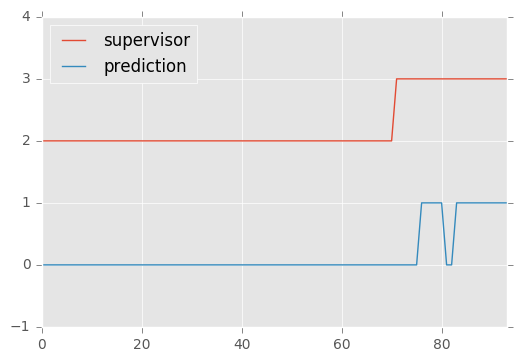

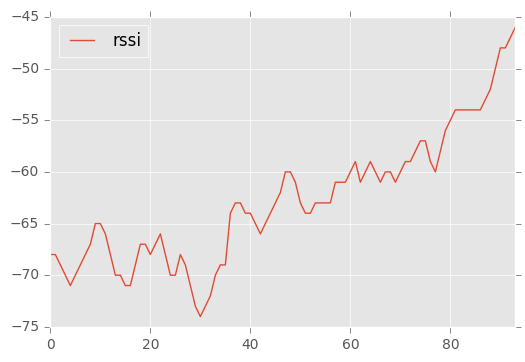

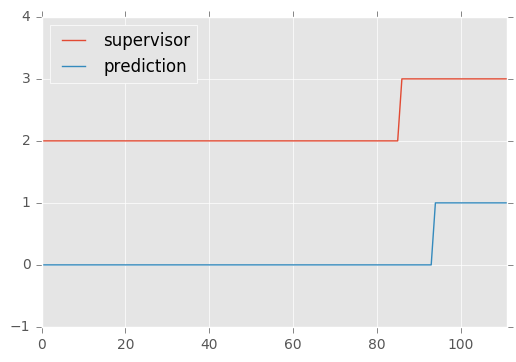

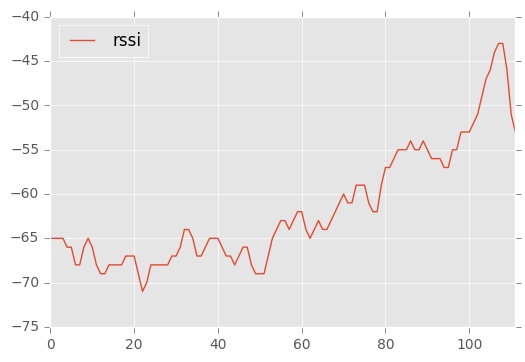

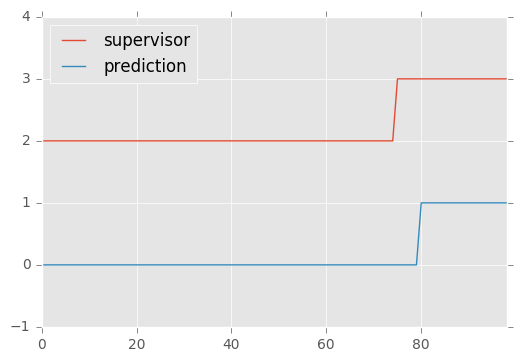

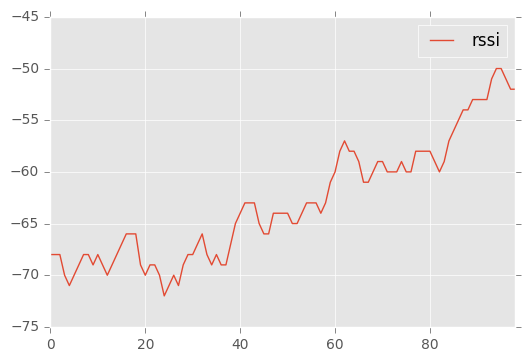

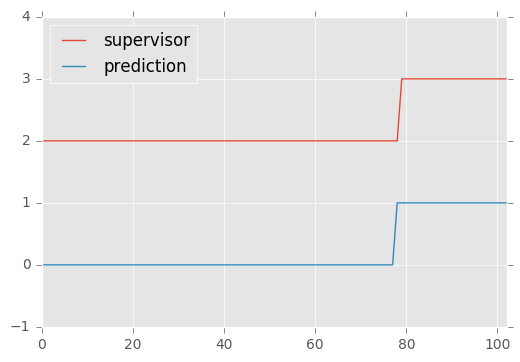

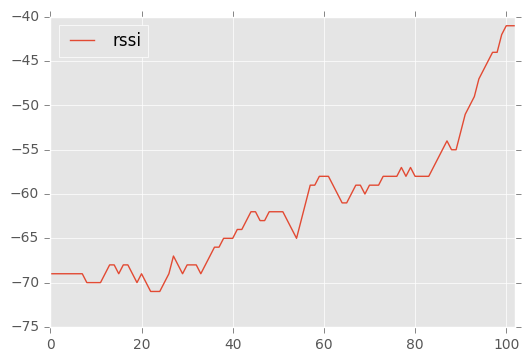

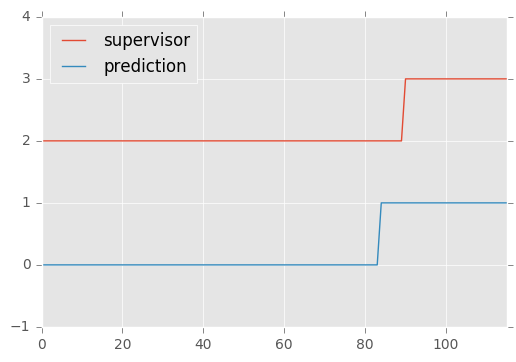

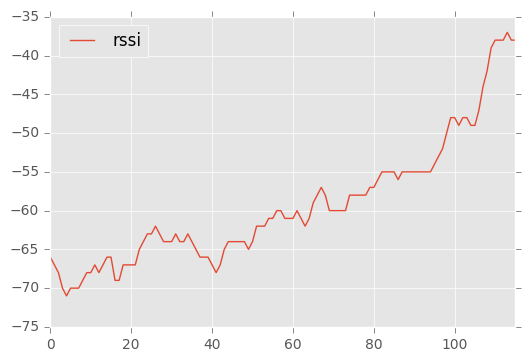

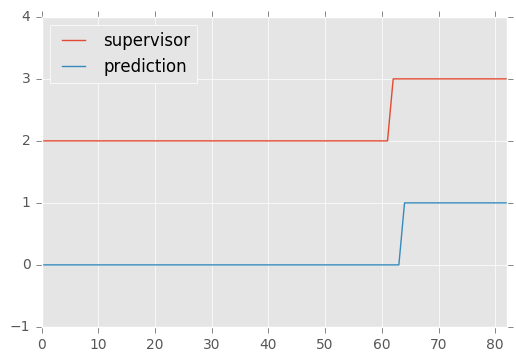

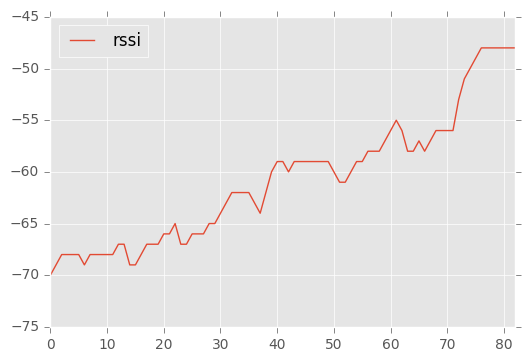

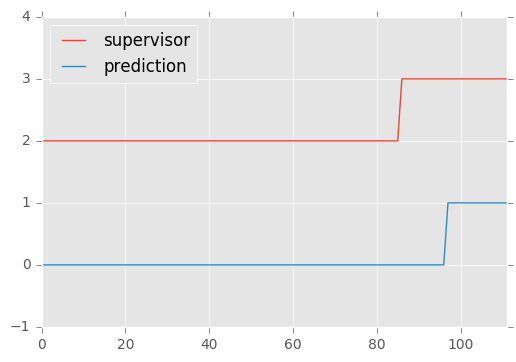

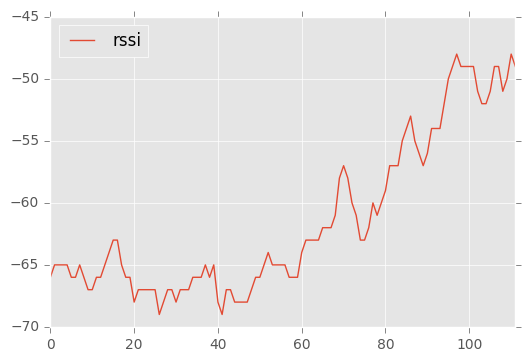

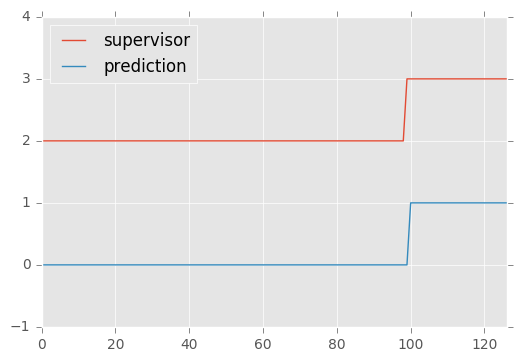

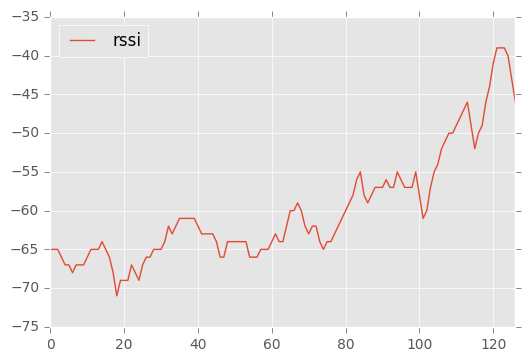

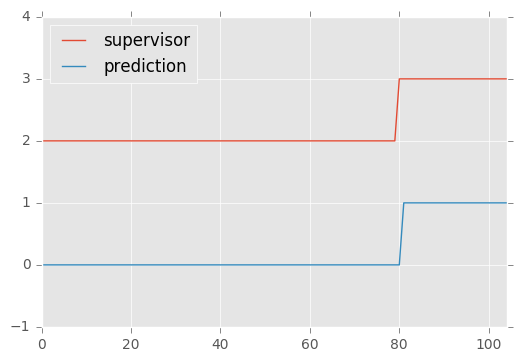

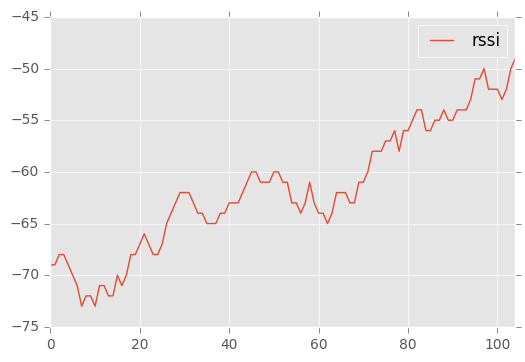

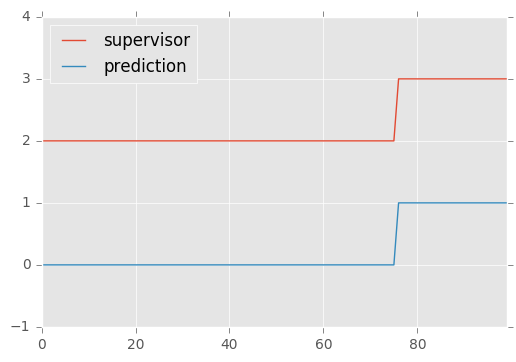

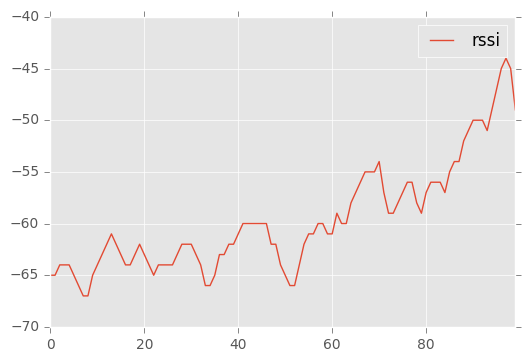

In [34]:
def plot_result(rssi, data, pred):
    prediction = pred
    supervisor = data
    df1 = pd.DataFrame({'rssi': rssi,
                        'supervisor': supervisor + 2,
                        'prediction': prediction})
    df1[['supervisor', 'prediction']].plot(ylim=[-1,4])
    df1[['rssi']].plot()

for k, d in train_data.items():
    print(k)
    pred = train_data[k][length_of_initial_sequences:,3]
    rssi = train_data[k][length_of_initial_sequences:,0] * 30 - 60
    data = train_data[k][length_of_initial_sequences:,2]
    plot_result(rssi, data, pred)

In [17]:
#train_data[random.choice(train_data.keys())]
random.choice(list(train_data.keys()))


'./input/20160907_01_gaze_kawachi.csv'